# ELEC_ENG_475 Final Project
## <p style="text-align: center;"> Prediction of Diabetes Status Using NHANES Data (2017-2018) </p>
### <p style="text-align: center;"> Group members: Juan Zhang, Ruitao Zhang, Ziliang Hong </p>
### <p style="text-align: center;"> NetID: FMB8549, MNR4714, PYQ6817 </p>

In this project, we aim to predict diabetes status using the 2017-2018 NHANES (National Health and Nutrition Examination Survey) dataset. The dataset includes a range of features such as demographic details, physical measurements, and laboratory results. We implemented and evaluated five machine learning models: **Logistic Regression**, **Lasso Regression**, **Random Forest**, **XGBoost**, and **Support Vector Machine (SVM)**. 

Our methodology involved:
- Data preprocessing
- Feature selection
- Model training and evaluation using a 5-fold cross-validation split

By comparing the performance of these models on metrics like accuracy, AUC, recall, and precision, we identified the most effective approach for diabetes prediction. This project demonstrates the application of diverse machine learning techniques in solving real-world biomedical classification problems.

In [77]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,recall_score,precision_score
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import RocCurveDisplay, auc,roc_curve,roc_auc_score

In [78]:
# Data organization
# Read the cleaned CSV file into a pandas DataFrame
data = pd.read_csv('merged_data_cleaned.csv')
# Remove rows where DIQ010 (diabetes status) equals 3 & 9 (likely represents missing or unknown values)
data = data[data['DIQ010']!=9]
data = data[data['DIQ010']!=3]
# Remove the SEQN ID column (likely a sequence or ID number that's no longer needed)
data = data.drop(columns=['SEQN'])
# Rename columns to more descriptive names for better readability:
data = data.rename(columns={'RIDAGEYR': 'age','RIAGENDR':'gender','RIDRETH1':'race',
                          'INDFMPIR':'IPR','BMXBMI':'BMI','BMXWAIST':'waist',
                          'LBXGLU':'glucose','DIQ010':'label','BPXSY1':'sys_bp',
                          'BPXDI1':"dia_bp"})

# Subtract 1 from label values (likely converting from 1/2 to 0/1 for binary classification)
data['label'] = data['label']-1

In [79]:
# Save the renameds DataFrame to a new CSV file named 'diabetes.csv'
data.to_csv('diabetes.csv', index=False)

### Section 1. Logistic Regression

In [80]:
# import logistic regression
from sklearn.linear_model import LogisticRegression
# result function
def get_results(acc_list, auc_list, recall_list, precision_list):
    # Convert metric lists to numpy arrays for easier statistical calculations
    acc_list = np.array(acc_list)
    auc_list = np.array(auc_list)
    recall_list = np.array(recall_list)
    precision_list = np.array(precision_list)

    # Print average and standard deviation for each metric
    # :.4f formats the float numbers to 4 decimal places
    print(f'Recall, Average:{recall_list.mean():.4f}, Std:{recall_list.std():.4f}')
    print(f'precision, Average:{precision_list.mean():.4f}, Std:{precision_list.std():.4f}')
    print(f'Accuracy, Average:{acc_list.mean():.4f}, Std:{acc_list.std():.4f}')
    print(f'AUC, Average:{auc_list.mean():.4f}, Std:{auc_list.std():.4f}')

# Read the preprocessed diabetes dataset
data = pd.read_csv('diabetes.csv')

# Initialize K-Fold cross-validator
# n_splits=5: divide data into 5 folds
# shuffle=True: randomly shuffle data before splitting
# random_state=42: set seed for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create empty list to store train and validation sets for each fold
folds = []

# Generate train and validation splits
for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
    # Get training data for current fold using index positions
    train_data = data.iloc[train_idx]
    # Get validation data for current fold using index positions
    val_data = data.iloc[val_idx]
    # Store the train-validation split in the folds list
    folds.append((train_data, val_data))

Training Fold 0 .....
Training Fold 1 .....
Training Fold 2 .....
Training Fold 3 .....
Training Fold 4 .....
Validation set
Recall, Average:0.9818, Std:0.0069
precision, Average:0.9254, Std:0.0058
Accuracy, Average:0.9160, Std:0.0080
AUC, Average:0.9257, Std:0.0115
---------------------------


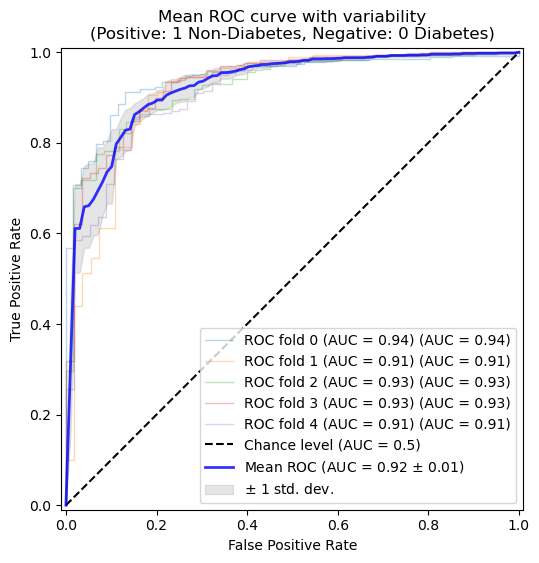

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    roc_auc_score,
    recall_score,
    precision_score,
    accuracy_score,
    auc,
)
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store performance metrics for validation
val_acc_list = []
val_auc_list = []
val_recall_list = []
val_precision_list = []

# Lists to store TPRs and AUCs for averaging
tprs = []
aucs = []

# Define a range for mean FPR
mean_fpr = np.linspace(0, 1, 100)

# Create a plot for ROC curves
fig, ax = plt.subplots(figsize=(6, 6))

# Loop through each fold for cross-validation
for fold in range(5):
    print(f"Training Fold {fold} .....")
    
    # Extract training and validation data for the current fold
    train_data = folds[fold][0]
    val_data = folds[fold][1]
    
    train_x = train_data.drop(columns=["label"])
    train_y = train_data["label"]

    val_x = val_data.drop(columns=["label"])
    val_y = val_data["label"]

    # Standardize the features
    standard_scaler = StandardScaler()
    train_x = standard_scaler.fit_transform(train_x)
    val_x = standard_scaler.transform(val_x)
    
    # Train the Logistic Regression model
    model = LogisticRegression()
    model.fit(train_x, train_y)
    
    # Generate the ROC curve for the current fold
    viz = RocCurveDisplay.from_estimator(
        model,
        val_x,
        val_y,
        name=f"ROC fold {fold} (AUC = {roc_auc_score(val_y, model.predict_proba(val_x)[:, 1]):.2f})",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == 5 - 1),
    )
    
    # Interpolate the TPR for the current fold
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    # ------------------- Validation Metrics -------------------
    y_pred_proba = model.predict_proba(val_x)[:, 1]  # Get probabilities for the positive class
    y_pred = model.predict(val_x)

    accuracy = accuracy_score(val_y, y_pred)
    val_acc_list.append(accuracy)
    
    auc_score = roc_auc_score(val_y, y_pred_proba)
    val_auc_list.append(auc_score)
    
    recall = recall_score(val_y, y_pred)
    val_recall_list.append(recall)
    
    precision = precision_score(val_y, y_pred)
    val_precision_list.append(precision)

# ------------------- Display Results -------------------
print("Validation set")
get_results(val_acc_list, val_auc_list, val_recall_list, val_precision_list)
print("---------------------------")

# ------------------- Mean ROC Curve -------------------
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

# Add standard deviation shading
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

# Configure the plot
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve with variability\n(Positive: 1 Non-Diabetes, Negative: 0 Diabetes)",
)
ax.legend(loc="lower right")
plt.show()


### Section 2. LASSO Regression

In [93]:
# import lasso
from sklearn.linear_model import Lasso

In [94]:
# result function
def get_results(acc_list,auc_list,recall_list,precision_list):    
    acc_list = np.array(acc_list)
    auc_list = np.array(auc_list)
    recall_list = np.array(recall_list)
    precision_list = np.array(precision_list)
    print(f'Recall, Average:{recall_list.mean():.4f}, Std:{recall_list.std():.4f}')
    print(f'precision, Average:{precision_list.mean():.4f}, Std:{precision_list.std():.4f}')
    print(f'Accuracy, Average:{acc_list.mean():.4f}, Std:{acc_list.std():.4f}')
    print(f'AUC, Average:{auc_list.mean():.4f}, Std:{auc_list.std():.4f}')
    
# Load the dataset from a CSV file
data = pd.read_csv('diabetes.csv')

# Set up a 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Split the data into training and validation sets for each fold
folds = []
for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
    train_data = data.iloc[train_idx]  # Training data for the current fold
    val_data = data.iloc[val_idx]      # Validation data for the current fold
    folds.append((train_data, val_data))  # Store the split


Training Fold 0 .....
Training Fold 1 .....
Training Fold 2 .....
Training Fold 3 .....
Training Fold 4 .....
Validation set
Recall, Average:0.9917, Std:0.0025
precision, Average:0.9012, Std:0.0063
Accuracy, Average:0.8990, Std:0.0067
AUC, Average:0.9320, Std:0.0097
--------------------


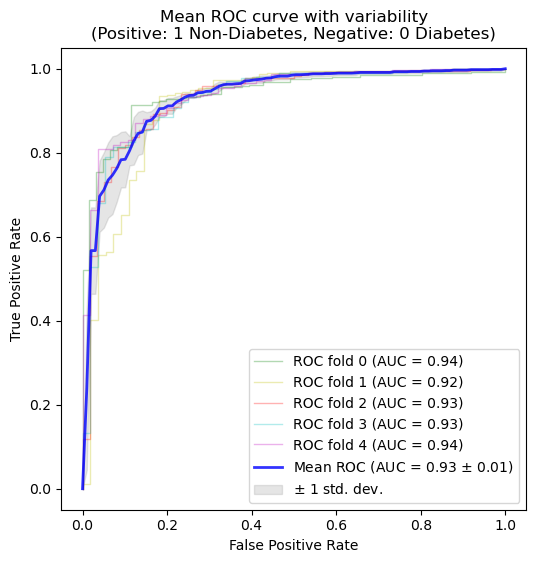

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    roc_auc_score,
    recall_score,
    precision_score,
    accuracy_score,
    auc,
)
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store performance metrics for validation
val_acc_list = []
val_auc_list = []
val_recall_list = []
val_precision_list = []

# Lists to store TPRs and AUCs for averaging
tprs = []
aucs = []

# Define a range for mean FPR
mean_fpr = np.linspace(0, 1, 100)

# Create a plot for ROC curves
fig, ax = plt.subplots(figsize=(6, 6))

# Loop through each fold for cross-validation
for fold in range(5):
    print(f"Training Fold {fold} .....")
    
    # Extract training and validation data for the current fold
    train_data = folds[fold][0]
    val_data = folds[fold][1]
    
    train_x = train_data.drop(columns=["label"])
    train_y = train_data["label"]

    val_x = val_data.drop(columns=["label"])
    val_y = val_data["label"]

    # Standardize the features
    standard_scaler = StandardScaler()
    train_x = standard_scaler.fit_transform(train_x)
    val_x = standard_scaler.transform(val_x)
    
    # Train the Logistic Regression model
    model = LogisticRegression()
    model.fit(train_x, train_y)
    
    # Generate the ROC curve for the current fold
    viz = RocCurveDisplay.from_estimator(
        model,
        val_x,
        val_y,
        name=f"ROC fold {fold} (AUC = {roc_auc_score(val_y, model.predict_proba(val_x)[:, 1]):.2f})",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == 5 - 1),
    )
    
    # Interpolate the TPR for the current fold
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    # ------------------- Validation Metrics -------------------
    y_pred_proba = model.predict_proba(val_x)[:, 1]  # Get probabilities for the positive class
    y_pred = model.predict(val_x)

    accuracy = accuracy_score(val_y, y_pred)
    val_acc_list.append(accuracy)
    
    auc_score = roc_auc_score(val_y, y_pred_proba)
    val_auc_list.append(auc_score)
    
    recall = recall_score(val_y, y_pred)
    val_recall_list.append(recall)
    
    precision = precision_score(val_y, y_pred)
    val_precision_list.append(precision)

# ------------------- Display Results -------------------
print("Validation set")
get_results(val_acc_list, val_auc_list, val_recall_list, val_precision_list)
print("---------------------------")

# ------------------- Mean ROC Curve -------------------
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

# Add standard deviation shading
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

# Configure the plot
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve with variability\n(Positive: 1 Non-Diabetes, Negative: 0 Diabetes)",
)
ax.legend(loc="lower right")
plt.show()


### Section 3. Random Forest

In [115]:
# Import random forest
from sklearn.ensemble import RandomForestClassifier
# Import the seaborn for data visualization
import seaborn as sns

In [116]:
# Function to print the average and standard deviation of metrics
def get_results(acc_list, auc_list, recall_list, precision_list):    
    acc_list = np.array(acc_list)
    auc_list = np.array(auc_list)
    recall_list = np.array(recall_list)
    precision_list = np.array(precision_list)

    # Print metrics
    print(f'Recall, Average:{recall_list.mean():.4f}, Std:{recall_list.std():.4f}')
    print(f'Precision, Average:{precision_list.mean():.4f}, Std:{precision_list.std():.4f}')
    print(f'Accuracy, Average:{acc_list.mean():.4f}, Std:{acc_list.std():.4f}')
    print(f'AUC, Average:{auc_list.mean():.4f}, Std:{auc_list.std():.4f}')

# Load the dataset from a CSV file
data = pd.read_csv('diabetes.csv')

# Drop the 'glucose' column if needed (optional)
# data = data.drop(columns='glucose')

# Set up a 5-fold cross-validation with shuffling and a fixed random state for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Split the data into training and validation sets for each fold
folds = []
for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
    train_data = data.iloc[train_idx]  # Training data for the current fold
    val_data = data.iloc[val_idx]      # Validation data for the current fold
    folds.append((train_data, val_data))  # Store the split


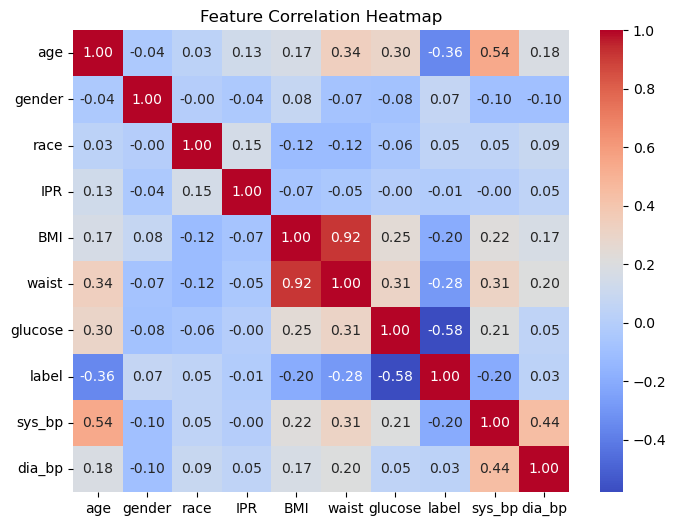

In [117]:
# Convert the dataset into a DataFrame
df = pd.DataFrame(data)

# Compute the correlation matrix for the DataFrame
corr_matrix = df.corr()

# Plot a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")  # Heatmap with annotations
plt.title("Feature Correlation Heatmap")  # Add a title to the plot
plt.show()  # Display the plot


Training Fold 0 .....
Training Fold 1 .....
Training Fold 2 .....
Training Fold 3 .....
Training Fold 4 .....


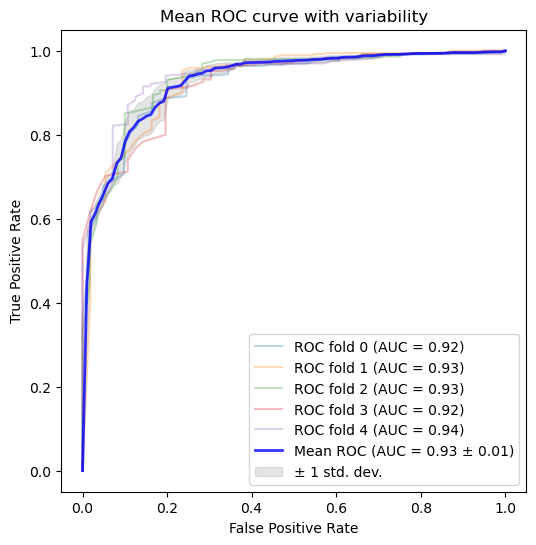

Validation set
Recall, Average:0.9692, Std:0.0123
Precision, Average:0.9409, Std:0.0081
Accuracy, Average:0.9208, Std:0.0079
AUC, Average:0.9297, Std:0.0055
--------------------
Average AUC across all folds: 0.93


In [121]:
# Initialize lists to store validation performance metrics
val_acc_list = []      
val_auc_list = [] 
val_recall_list = []
val_precision_list = []

# Lists to store TPRs and AUCs
tprs = []
aucs = []

# Define a range for mean FPR
mean_fpr = np.linspace(0, 1, 100)

# Create a plot for ROC curves
fig, ax = plt.subplots(figsize=(6, 6))

# Dictionary to store trained models for each fold
models = {}

# Perform 5-fold cross-validation
for fold in range(5):        
    print(f"Training Fold {fold} .....")

    # Get training and validation data for the current fold
    train_data = folds[fold][0] 
    val_data = folds[fold][1]
    
    # Separate features (X) and labels (y) for training and validation sets
    train_x = train_data.drop(columns=['label'])
    train_y = train_data['label']

    val_x = val_data.drop(columns=['label'])
    val_y = val_data['label']

    # Standardize the features
    standard_scaler = StandardScaler()
    train_x = standard_scaler.fit_transform(train_x)
    val_x = standard_scaler.transform(val_x)

    # Initialize and train the RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(train_x, train_y)
    models[f'fold{fold}'] = model
    
    # ------------------- ROC Curve -------------------
    y_pred_proba = model.predict_proba(val_x)[:, 1]  # Get probabilities for the positive class
    
    # Check if val_y contains both classes
    if len(np.unique(val_y)) > 1:  # Ensure both 0 and 1 are present
        fpr, tpr, _ = roc_curve(val_y, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Interpolate the TPR for consistent mean calculation
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
        # Plot ROC curve for the fold
        ax.plot(
            fpr, tpr,
            label=f"ROC fold {fold} (AUC = {roc_auc:.2f})",
            alpha=0.3
        )
    else:
        print(f"Fold {fold} skipped: val_y contains only one class.")
        aucs.append(np.nan)  # Add NaN for this fold if AUC can't be computed
    
    # ------------------- Validation Metrics -------------------
    y_pred = model.predict(val_x)
    
    # Calculate and store validation metrics
    accuracy = accuracy_score(val_y, y_pred)
    val_acc_list.append(accuracy)
    
    recall = recall_score(val_y, y_pred, zero_division=0)
    val_recall_list.append(recall)
    
    precision = precision_score(val_y, y_pred, zero_division=0)
    val_precision_list.append(precision)

    auc_score = roc_auc if len(np.unique(val_y)) > 1 else np.nan
    val_auc_list.append(auc_score)

# ------------------- Mean ROC Curve -------------------
valid_aucs = [auc for auc in aucs if not np.isnan(auc)]  # Filter out NaN AUCs
if valid_aucs:
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(valid_aucs)
    std_auc = np.std(valid_aucs)

    ax.plot(
        mean_fpr, mean_tpr,
        color="b",
        label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
        lw=2, alpha=0.8
    )

    # Add standard deviation shading
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr, tprs_lower, tprs_upper,
        color="grey", alpha=0.2,
        label="± 1 std. dev."
    )
else:
    print("No valid AUCs were computed. Cannot plot mean ROC curve.")

# Configure the plot
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve with variability"
)
ax.legend(loc="lower right")

# Display the plot
plt.show()

# ------------------- Final Results -------------------
# Display aggregated results for the validation set
print("Validation set")
get_results(val_acc_list, val_auc_list, val_recall_list, val_precision_list)
print("--------------------")

# ------------------- Average AUC -------------------
if valid_aucs:
    average_auc = np.mean(valid_aucs)
    print(f"Average AUC across all folds: {average_auc:.2f}")
else:
    print("Average AUC cannot be computed: No valid AUCs.")

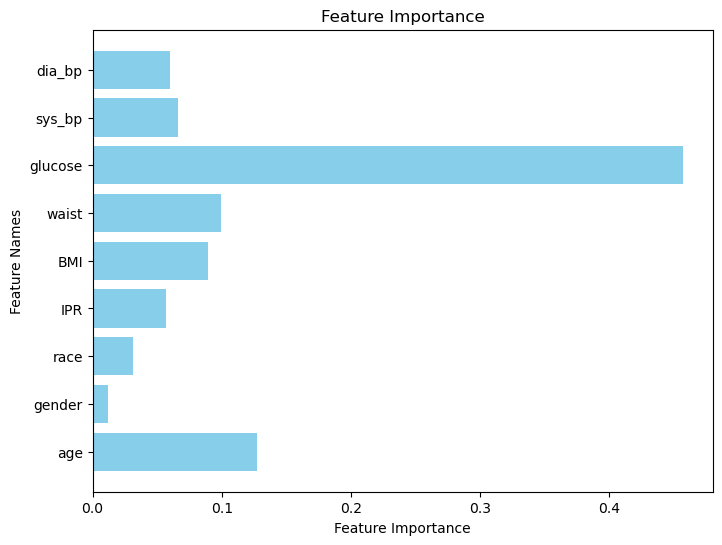

In [22]:
# Get the model for fold 1
rf = models['fold1']

# Get feature importances and feature names
importances = rf.feature_importances_
features = data.drop(columns=['label']).columns

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(features, importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance")
plt.show()


### Section 4. Extreme Gradient Boosting (XGBoost)

In [107]:
# Import the XGBoost library, which is widely used for efficient and scalable gradient boosting algorithms
import xgboost as xgb

In [108]:
# Function to print averages and standard deviations of metrics
def get_results(acc_list, auc_list, recall_list, precision_list):    
    acc_list = np.array(acc_list)
    auc_list = np.array(auc_list)
    recall_list = np.array(recall_list)
    precision_list = np.array(precision_list)
    print(f'Recall, Average:{recall_list.mean():.4f}, Std:{recall_list.std():.4f}')
    print(f'Precision, Average:{precision_list.mean():.4f}, Std:{precision_list.std():.4f}')
    print(f'Accuracy, Average:{acc_list.mean():.4f}, Std:{acc_list.std():.4f}')
    print(f'AUC, Average:{auc_list.mean():.4f}, Std:{auc_list.std():.4f}')

# Load the dataset
data = pd.read_csv('diabetes.csv')

# Split data into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
    train_data = data.iloc[train_idx]  # Training data for the fold
    val_data = data.iloc[val_idx]      # Validation data for the fold
    folds.append((train_data, val_data))  # Store the split


Training Fold 0 .....


/opt/anaconda3/envs/ML/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:18:34] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Fold 1 .....


/opt/anaconda3/envs/ML/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:18:34] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Fold 2 .....
Training Fold 3 .....


/opt/anaconda3/envs/ML/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:18:35] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:18:35] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Fold 4 .....


/opt/anaconda3/envs/ML/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:18:35] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


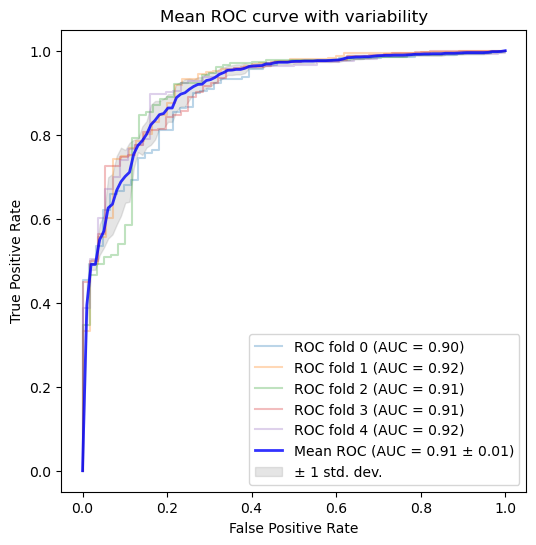

Validation set
Recall, Average:0.9572, Std:0.0129
Precision, Average:0.9412, Std:0.0077
Accuracy, Average:0.9113, Std:0.0076
AUC, Average:0.9116, Std:0.0063
--------------------


In [109]:
# Initialize lists to store validation metrics
val_acc_list = []       # Accuracy
val_auc_list = []       # AUC
val_recall_list = []    # Recall
val_precision_list = [] # Precision

# Lists to store TPRs and AUCs
tprs = []
aucs = []

# Define a range for mean FPR
mean_fpr = np.linspace(0, 1, 100)

# Create a plot for ROC curves
fig, ax = plt.subplots(figsize=(6, 6))

# Perform 5-fold cross-validation
for fold in range(5):        
    print(f"Training Fold {fold} .....")

    # Get training and validation data for the current fold
    train_data = folds[fold][0]
    val_data = folds[fold][1]
    
    # Separate features and labels
    train_x = train_data.drop(columns=['label'])
    train_y = train_data['label']
    val_x = val_data.drop(columns=['label'])
    val_y = val_data['label']

    # Standardize features
    standard_scaler = StandardScaler()
    train_x = standard_scaler.fit_transform(train_x)
    val_x = standard_scaler.transform(val_x)

    # Initialize and train XGBoost model
    model = xgb.XGBClassifier(
        use_label_encoder=False, 
        eval_metric='auc', 
        n_estimators=200, 
        max_depth=30, 
        learning_rate=0.3
    )
    model.fit(train_x, train_y, verbose=True)
    
    # ------------------- ROC Curve -------------------
    y_pred_proba = model.predict_proba(val_x)[:, 1]  # Probabilities for positive class
    fpr, tpr, _ = roc_curve(val_y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Interpolate the TPR for consistent mean calculation
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    # Plot ROC curve for the fold
    ax.plot(
        fpr, tpr,
        label=f"ROC fold {fold} (AUC = {roc_auc:.2f})",
        alpha=0.3
    )

    # ------------------- Validation Metrics -------------------
    y_pred = model.predict(val_x)
    
    # Calculate and store validation metrics
    val_acc_list.append(accuracy_score(val_y, y_pred))       # Accuracy
    val_auc_list.append(roc_auc_score(val_y, y_pred_proba))  # AUC
    val_recall_list.append(recall_score(val_y, y_pred))      # Recall
    val_precision_list.append(precision_score(val_y, y_pred)) # Precision

# ------------------- Mean ROC Curve -------------------
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr, mean_tpr,
    color="b",
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
    lw=2, alpha=0.8
)

# Add standard deviation shading
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr, tprs_lower, tprs_upper,
    color="grey", alpha=0.2,
    label="± 1 std. dev."
)

# Configure the plot
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve with variability"
)
ax.legend(loc="lower right")

# Display the plot
plt.show()

# ------------------- Final Results -------------------
# Print aggregated validation results
print("Validation set")
get_results(val_acc_list, val_auc_list, val_recall_list, val_precision_list)
print("--------------------")


### Section 5. Support Vector Machine (SVM)

In [110]:
# Import the Support Vector Classifier (SVC) from scikit-learn's SVM module
from sklearn.svm import SVC

In [111]:
# Function to print the average and standard deviation of metrics
def get_results(acc_list, auc_list, recall_list, precision_list):    
    acc_list = np.array(acc_list)  # Convert accuracy list to array
    auc_list = np.array(auc_list)  # Convert AUC list to array
    recall_list = np.array(recall_list)  # Convert recall list to array
    precision_list = np.array(precision_list)  # Convert precision list to array

    # Print metrics
    print(f'Recall, Average:{recall_list.mean():.4f}, Std:{recall_list.std():.4f}')
    print(f'Precision, Average:{precision_list.mean():.4f}, Std:{precision_list.std():.4f}')
    print(f'Accuracy, Average:{acc_list.mean():.4f}, Std:{acc_list.std():.4f}')
    print(f'AUC, Average:{auc_list.mean():.4f}, Std:{auc_list.std():.4f}')


In [112]:
# Load the dataset
data = pd.read_csv('diabetes.csv')

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Split the data into folds
folds = []
for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
    train_data = data.iloc[train_idx]  # Training data
    val_data = data.iloc[val_idx]      # Validation data
    folds.append((train_data, val_data))  # Store the split


Training Fold 0 .....
Training Fold 1 .....
Training Fold 2 .....
Training Fold 3 .....
Training Fold 4 .....


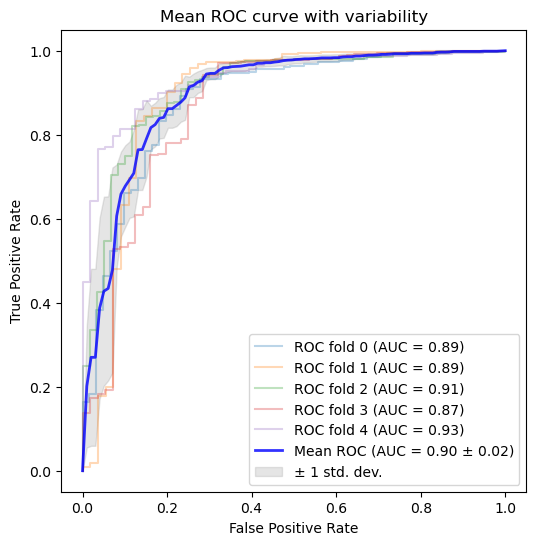

Validation set
Recall, Average:0.9692, Std:0.0097
Precision, Average:0.9346, Std:0.0157
Accuracy, Average:0.9146, Std:0.0133
AUC, Average:0.8980, Std:0.0229
--------------------


In [113]:
# Lists to store validation metrics
val_acc_list = []       # Accuracy
val_auc_list = []       # AUC
val_recall_list = []    # Recall
val_precision_list = [] # Precision

# Lists to store TPRs and AUCs
tprs = []
aucs = []

# Define a range for mean FPR
mean_fpr = np.linspace(0, 1, 100)

# Create a plot for ROC curves
fig, ax = plt.subplots(figsize=(6, 6))

# 5-fold cross-validation
for fold in range(5):
    print(f"Training Fold {fold} .....")

    # Get training and validation data
    train_data = folds[fold][0]
    val_data = folds[fold][1]
    
    # Separate features and labels
    train_x = train_data.drop(columns=['label'])
    train_y = train_data['label']
    val_x = val_data.drop(columns=['label'])
    val_y = val_data['label']

    # Standardize features
    standard_scaler = StandardScaler()
    train_x = standard_scaler.fit_transform(train_x)
    val_x = standard_scaler.transform(val_x)

    # Train SVC model with RBF kernel
    model = SVC(kernel='rbf', probability=True, C=5)
    model.fit(train_x, train_y)

    # ------------------- ROC Curve -------------------
    y_pred_proba = model.predict_proba(val_x)[:, 1]  # Probabilities for positive class
    fpr, tpr, _ = roc_curve(val_y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Interpolate the TPR for consistent mean calculation
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    # Plot ROC curve for the fold
    ax.plot(
        fpr, tpr,
        label=f"ROC fold {fold} (AUC = {roc_auc:.2f})",
        alpha=0.3
    )

    # ------------------- Validation Metrics -------------------
    y_pred = model.predict(val_x)
    
    # Calculate and store validation metrics
    val_acc_list.append(accuracy_score(val_y, y_pred))       # Accuracy
    val_auc_list.append(roc_auc_score(val_y, y_pred_proba))  # AUC
    val_recall_list.append(recall_score(val_y, y_pred))      # Recall
    val_precision_list.append(precision_score(val_y, y_pred)) # Precision

# ------------------- Mean ROC Curve -------------------
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr, mean_tpr,
    color="b",
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
    lw=2, alpha=0.8
)

# Add standard deviation shading
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr, tprs_lower, tprs_upper,
    color="grey", alpha=0.2,
    label="± 1 std. dev."
)

# Configure the plot
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve with variability"
)
ax.legend(loc="lower right")

# Display the plot
plt.show()

# ------------------- Final Results -------------------
# Print aggregated validation results
print("Validation set")
get_results(val_acc_list, val_auc_list, val_recall_list, val_precision_list)
print("--------------------")
